In [1]:
### Ref: https://github.com/ageron/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb


# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# For basic Image IO
import IPython.display as display
from PIL import Image

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


def make_dirs(path, clean=False):
    if not os.path.exists(path):
        os.makedirs(path)
    else: #Empty the directory
        if clean == True:
            shutil.rmtree(path)
    return
    

#Add basic logging
import logging     
make_dirs("logs/events")
logging.basicConfig(filename=os.path.join("logs/events",'cs230_keras_notebook.log'),
                    level=logging.DEBUG,
                   format='%(asctime)s %(message)s', 
                    datefmt='%m/%d/%Y %I:%M:%S %p')

#Load Extensions
%load_ext tensorboard
tensorboard_dir = "logs/tensorboard"
make_dirs(tensorboard_dir)
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(tensorboard_dir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [2]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
def show_batch(image_batch, label_batch, class_indices):
    print("image_batch_shape {}".format(image_batch.shape))
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        label_indices = np.argmax(label_batch[n])
        
        #Flip the dictionary from class_indices to indices_class
        indices_class = dict((v,k) for k, v in class_indices.items()) 
        plt.imshow(image_batch[n])
        plt.title(label_batch[n])
        plt.title(indices_class.get(label_indices))
        plt.axis('off')

In [6]:
def show_batch_grayscale(image_batch, label_batch):
    print("image_batch_shape {}".format(image_batch.shape))
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(np.squeeze(image_batch[n]), cmap='gray',interpolation='none')
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

In [7]:
#This assumed that you have checked out the data repo next to the object detection repo
# Data repo can be found over here: https://github.com/nandini-sundar/CS230-TrashNet-YOLO-Labeled
import pathlib
data_dir = pathlib.Path("../CS230-TrashNet-YOLO-Labeled")

In [8]:
class_names_file = data_dir.joinpath("classes.txt")
class_names = pd.read_csv(class_names_file, header = None, sep='\n', names=['classes'])
print(class_names.values)
n_classes = len(class_names)
print(n_classes)

[['glass']
 ['metal']
 ['plastic']
 ['cardboard']
 ['trash']
 ['paper']]
6


In [9]:
import shutil

data_images_dir = data_dir.joinpath("Images")
CLASS_NAMES = np.array([item.name for item in data_images_dir.glob('*') if item.name != "LICENSE.txt"])

CLASS_NAMES

#Make directory to save generated images
generated_train_images_dir = data_dir.joinpath("generated/train")
generated_validation_images_dir = data_dir.joinpath("generated/validation")
generated_test_images_dir = data_dir.joinpath("generated/test")
if not os.path.exists(generated_train_images_dir):
    os.makedirs(generated_train_images_dir)
    os.makedirs(generated_validation_images_dir)
    os.makedirs(generated_test_images_dir)
else: #Empty the directory
    shutil.rmtree(generated_train_images_dir)
    shutil.rmtree(generated_validation_images_dir)
    shutil.rmtree(generated_test_images_dir)
    
    os.makedirs(generated_train_images_dir)
    os.makedirs(generated_validation_images_dir)
    os.makedirs(generated_test_images_dir)
    
logging.info("Generated train images stored at {}".format(generated_train_images_dir))
logging.info("Generated validation images stored at {}".format(generated_validation_images_dir))
logging.info("Generated test images stored at {}".format(generated_test_images_dir))

In [10]:
image_count = len(list(data_images_dir.glob('*/*.jpg')))
print("Total number of input images {}".format(image_count))

Total number of input images 2527


In [11]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [12]:
def get_dataframe_for_generator(filename, x_col, y_col):
    df = pd.read_csv(data_dir.joinpath(filename), names=[x_col])
    
    #Convert foldernames in filepaths to class names.
    #Expects filepath in format : ./Images/paper/paper283.jpg
    df[y_col] = df[x_col].apply(lambda x: os.path.basename(os.path.dirname(x)))
    
    return df
    
x_col = "filename"
y_col = 'class_list'

train_df = get_dataframe_for_generator(filename='train.txt', x_col=x_col, y_col=y_col)
logging.debug("Here are some train images ")
logging.debug(train_df)

test_df = get_dataframe_for_generator(filename='test.txt', x_col=x_col, y_col=y_col)
logging.debug("Here are some test images ")
logging.debug(test_df)

In [13]:
train_df

,filename,class_list
0,./Images/paper/paper283.jpg,paper
1,./Images/paper/paper297.jpg,paper
2,./Images/paper/paper526.jpg,paper
3,./Images/paper/paper240.jpg,paper
4,./Images/paper/paper254.jpg,paper
...,...,...
2270,./Images/plastic/plastic405.jpg,plastic
2271,./Images/plastic/plastic411.jpg,plastic
2272,./Images/plastic/plastic377.jpg,plastic
2273,./Images/plastic/plastic439.jpg,plastic


In [14]:
train_df[x_col].str.split(pat='/')

0           [., Images, paper, paper283.jpg]
1           [., Images, paper, paper297.jpg]
2           [., Images, paper, paper526.jpg]
3           [., Images, paper, paper240.jpg]
4           [., Images, paper, paper254.jpg]
                        ...                 
2270    [., Images, plastic, plastic405.jpg]
2271    [., Images, plastic, plastic411.jpg]
2272    [., Images, plastic, plastic377.jpg]
2273    [., Images, plastic, plastic439.jpg]
2274    [., Images, plastic, plastic388.jpg]
Name: filename, Length: 2275, dtype: object

In [15]:
def split_and_join(s, repl):
    splits = str.split(s, '/')
    splits[1] = repl
    return "/".join(splits)

In [16]:
train_df['label_path']  = train_df[x_col].str.replace(pat='.jpg', repl='.txt')
train_df['label_path'] = train_df['label_path'].apply(lambda x: split_and_join(x, 'Labels'))

In [17]:
train_df

,filename,class_list,label_path
0,./Images/paper/paper283.jpg,paper,./Labels/paper/paper283.txt
1,./Images/paper/paper297.jpg,paper,./Labels/paper/paper297.txt
2,./Images/paper/paper526.jpg,paper,./Labels/paper/paper526.txt
3,./Images/paper/paper240.jpg,paper,./Labels/paper/paper240.txt
4,./Images/paper/paper254.jpg,paper,./Labels/paper/paper254.txt
...,...,...,...
2270,./Images/plastic/plastic405.jpg,plastic,./Labels/plastic/plastic405.txt
2271,./Images/plastic/plastic411.jpg,plastic,./Labels/plastic/plastic411.txt
2272,./Images/plastic/plastic377.jpg,plastic,./Labels/plastic/plastic377.txt
2273,./Images/plastic/plastic439.jpg,plastic,./Labels/plastic/plastic439.txt


In [18]:
#train_df['label_path'].apply(lambda label_path : pd.read_csv(data_dir.joinpath(label_path) ))
label_format = ['class_id', 'x', 'y', 'w', 'h']

labels_list = []
for label_file in train_df['label_path']:
    label_file = data_dir.joinpath(label_file)
    df_label_indiv = pd.read_csv(label_file, sep=" ", names=label_format)
    
    #Keeping only first row of the dataframe for simplicity
    df_label_indiv = df_label_indiv.head(1)
    labels_list.append(df_label_indiv)

df_label_all = pd.concat(labels_list)
df_label_all.reset_index(drop=True, inplace=True)
#print(df_label_all)

df_label_all.index = train_df.index
train_df_x_y = pd.concat([train_df, df_label_all], axis=1, sort=False)
train_df_x_y

,filename,class_list,label_path,class_id,x,y,w,h
0,./Images/paper/paper283.jpg,paper,./Labels/paper/paper283.txt,5,0.503906,0.519531,0.992188,0.966146
1,./Images/paper/paper297.jpg,paper,./Labels/paper/paper297.txt,5,0.467773,0.503906,0.916016,0.986979
2,./Images/paper/paper526.jpg,paper,./Labels/paper/paper526.txt,5,0.453125,0.503906,0.890625,0.981771
3,./Images/paper/paper240.jpg,paper,./Labels/paper/paper240.txt,5,0.393555,0.585938,0.775391,0.828125
4,./Images/paper/paper254.jpg,paper,./Labels/paper/paper254.txt,5,0.550781,0.503906,0.894531,0.955729
...,...,...,...,...,...,...,...,...
2270,./Images/plastic/plastic405.jpg,plastic,./Labels/plastic/plastic405.txt,2,0.501953,0.505208,0.988281,0.989583
2271,./Images/plastic/plastic411.jpg,plastic,./Labels/plastic/plastic411.txt,2,0.689453,0.613281,0.617188,0.648438
2272,./Images/plastic/plastic377.jpg,plastic,./Labels/plastic/plastic377.txt,2,0.490234,0.404948,0.523438,0.695312
2273,./Images/plastic/plastic439.jpg,plastic,./Labels/plastic/plastic439.txt,2,0.588867,0.605469,0.365234,0.789062


In [19]:
def deconvert(yolobox, img_width,img_height ):
    
    ox = float(yolobox[0])
    oy = float(yolobox[1])
    ow = float(yolobox[2])
    oh = float(yolobox[3])
    x = ox*img_width
    y = oy*img_height
    w = ow*img_width
    h = oh*img_height
    xmax = (((2*x)+w)/2)
    xmin = xmax-w
    ymax = (((2*y)+h)/2)
    ymin = ymax-h
    print(xmin, ymin, xmax, ymax)
    return int(xmin),int(xmax),int(ymin),int(ymax)

In [20]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                 validation_split=0.25)

train_generator = image_generator.flow_from_dataframe(dataframe=train_df_x_y,
                                                     directory=data_dir,
                                                     x_col=x_col,
                                                     y_col="class_list",
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=SEED,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical',
                                                    save_to_dir=generated_train_images_dir,
                                                     subset="training",
                                                      subdirectories=True,
                                                    save_prefix="gen-")

Found 1707 validated image filenames belonging to 6 classes.


In [21]:
validation_data_gen = image_generator.flow_from_dataframe(dataframe=train_df_x_y,
                                                     directory=data_dir,
                                                     x_col=x_col,
                                                     y_col="class_list",
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                    seed=SEED,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical',
                                                    save_to_dir=generated_validation_images_dir,
                                                     subset="validation",
                                                    save_prefix="gen-")

Found 568 validated image filenames belonging to 6 classes.


In [22]:
#Notice that y_col = None
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen = test_generator.flow_from_dataframe(dataframe=test_df,
                                                     directory=data_dir,
                                                     x_col=x_col,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                    seed=SEED,
                                                   class_mode=None, 
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    save_to_dir=generated_test_images_dir,
                                                    save_prefix="gen-")

Found 252 validated image filenames.


In [23]:
image_batch, label_batch = next(train_generator)
image_batch.shape

(32, 224, 224, 3)

In [24]:
len(label_batch)

32

image_batch_shape (32, 224, 224, 3)


/home/hnkulkarni/envs/cs230/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


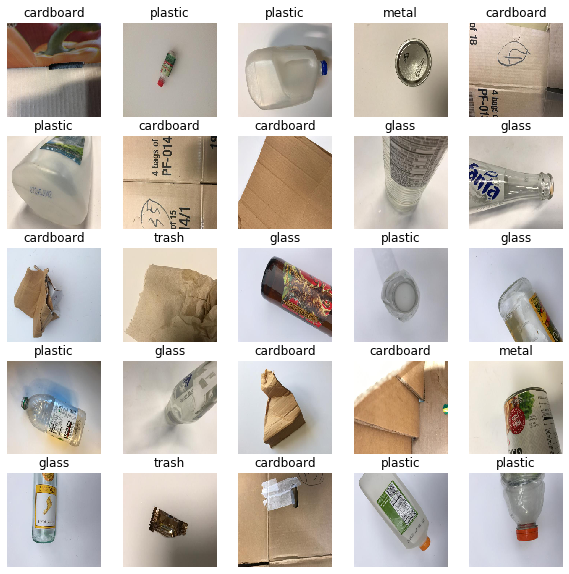

In [25]:
show_batch(image_batch, label_batch, train_generator.class_indices)

In [43]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("cs230_keras_trashnet_classification.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [37]:
base_model = keras.applications.xception.Xception(weights='imagenet',
                                                 include_top = False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
#loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output])

In [38]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_4
13 block2_pool
14 batch_normalization_4
15 add_12
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_5
23 block3_pool
24 batch_normalization_5
25 add_13
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_6
33 block4_pool
34 batch_normalization_6
35 add_14
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_15
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [39]:
for layer in base_model.layers:
    layer.trainable = False
    
adam = tf.keras.optimizers.Adam(lr=0.01) #Higher lerarning rate
model.compile(adam, loss=['categorical_crossentropy'], metrics=['accuracy'])

In [ ]:
history = model.fit_generator(train_generator, epochs=2, workers=8, 
                                       steps_per_epoch=train_generator.samples // BATCH_SIZE, 
                                       shuffle=True,
                            validation_data=validation_data_gen,
                             callbacks=[tensorboard_cb, 
                                        checkpoint_cb,
                                       early_stopping_cb,
                                       reduce_lr_cb])

Epoch 1/2
53/53 [==============================] - 30s 566ms/step - loss: 0.1651 - accuracy: 0.9588 - val_loss: 14.6582 - val_accuracy: 0.0458
Epoch 2/2
50/53 [===========================>..] - ETA: 1s - loss: 0.1481 - accuracy: 0.9601

In [ ]:
#Unfreeze the layers from the base model
for layer in base_model.layers:
    layer.trainable = True
    
adam = tf.keras.optimizers.Adam(lr=0.000001) #Lower the lerarning rate lerarning rate
model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(train_generator, epochs=20, workers=8, 
                                       steps_per_epoch=train_generator.samples // BATCH_SIZE, 
                                       shuffle=True,
                              validation_data=validation_data_gen,
                             callbacks=[tensorboard_cb, 
                                        checkpoint_cb,
                                       early_stopping_cb,
                                       reduce_lr_cb])

In [ ]:
train_generator.class_indices

In [ ]:
indices_class = dict((v,k) for k, v in train_generator.class_indices.items())

In [ ]:
print(indices_class)

In [ ]:
show_batch(image_batch, label_batch, train_generator.class_indices)